In [2]:
data_url = {
    'test': 'https://transfer.sh/1fbFgD7w4F/mnist_test.csv',
    'train': 'https://transfer.sh/OfL7x1GAjx/mnist_train.csv'
}

In [3]:
import os
import subprocess

if (not os.path.exists('./data/mnist_train.csv')):
    os.makedirs('./data', exist_ok=True)
    for key in data_url:
        print('Downloading', key, 'data...')
        subprocess.call(['curl', data_url[key], '-o', './data/mnist_' + key + '.csv'])

In [4]:
import pandas as pd

data = pd.read_csv('data/mnist_train.csv')
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Idea

Create 10 model, model i answer whether the picture is of the i-th digit

In [5]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class LossFunction:

    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def loss(self, a : np.ndarray):
        prob = sigmoid(np.dot(self.X, a))
        values = - self.y * np.log(prob) - (1 - self.y) * np.log(1 - prob)
        return np.nansum(values) / self.y.shape[0]

    def gradient(self, a : np.ndarray):
        prob = sigmoid(np.dot(self.X, a))
        sub_coefficient = -(self.y - prob) 
        return np.dot(self.X.T, sub_coefficient) / self.y.shape[0]
    
    def precision(self, a : np.ndarray):
        prob = sigmoid(np.dot(self.X, a))
        prob = np.array(prob >= 0.5, dtype=np.int32)
        return np.sum(prob == self.y) / self.y.shape[0]

### Data


In [7]:
X = data.drop('label', axis=1).values
# X: shape m x 784
#append a column of 1s
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = data['label'].values
X.shape, y.shape

((60000, 785), (60000,))

In [6]:
loss_functions = []
for digit in range(10):
    y_digit = np.array(y == digit, dtype=np.int32)
    loss_functions.append(LossFunction(X, y_digit))

In [7]:
loss_functions

### Train data

In [13]:
def gradient_descent(loss_func, starting_point, learning_rate = 0.00001, num_steps = 40, precision=0.00001):
    cur_point = starting_point
    for i in range(num_steps):
        grad = loss_func.gradient(cur_point)
        print("Iteration {}: loss = {}, precision = {}".format(i, loss_func.loss(cur_point), loss_func.precision(cur_point)))
        cur_point = cur_point - learning_rate * grad
        if np.linalg.norm(grad) < precision:
            break
    return cur_point

In [9]:
optimal_points = []

for digit in range(10):
    optimal_point = gradient_descent(loss_functions[digit], np.zeros(X.shape[1]))
    print("Accuracy for digit {}: {}".format(digit, loss_functions[digit].precision(optimal_point)))
    optimal_points.append(optimal_point)

Accuracy for digit 0: 0.9843333333333333
Accuracy for digit 1: 0.98625
Accuracy for digit 2: 0.9673333333333334
Accuracy for digit 3: 0.96225
Accuracy for digit 4: 0.9729333333333333
Accuracy for digit 5: 0.9528166666666666
Accuracy for digit 6: 0.9795666666666667
Accuracy for digit 7: 0.9779166666666667
Accuracy for digit 8: 0.9358166666666666
Accuracy for digit 9: 0.9471333333333334


### Inference

In [16]:
def infer(X, optimal_points):
    prob = np.zeros((X.shape[0], 10))
    for digit in range(10):
        prob[:, digit] = sigmoid(np.dot(X, optimal_points[digit]))
    return np.argmax(prob, axis=1), prob

In [11]:
import matplotlib.pyplot as plt

def draw_digit(data, row_id):
    row = data.iloc[row_id]
    label = row['label']
    image = row.drop('label').values.reshape(28, 28)
    plt.title('Digit Label = {}'.format(label))
    plt.imshow(image, cmap='gray')
    plt.show()

In [12]:
data_test = pd.read_csv('data/mnist_test.csv')
X_test = data_test.drop('label', axis=1).values
X_test = np.concatenate((np.ones((X_test.shape[0], 1)), X_test), axis=1)
y_test = data_test['label'].values


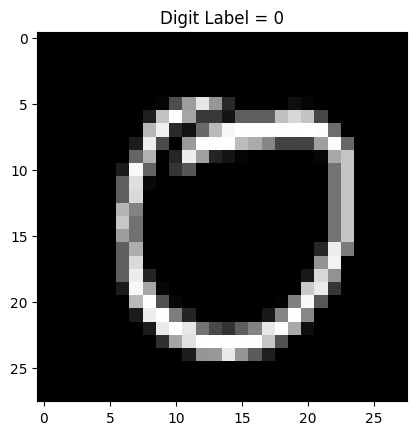

In [43]:
draw_digit(data_test, 2023)

In [46]:
infer(np.array([X_test[2003]]), optimal_points)

(array([5], dtype=int64),
 array([[0.01650046, 0.01635738, 0.00897801, 0.08814713, 0.04182052,
         0.53346969, 0.03824936, 0.00192412, 0.50665186, 0.02340841]]))

In [51]:
_, prob = infer(np.array([X_test[2003]]), optimal_points)
# calculate sum of probabilities
sum = np.sum(prob)
new_prob = prob / sum
print(np.sum(new_prob))
new_prob

0.9999999999999999


array([[0.01293639, 0.01282422, 0.00703878, 0.06910753, 0.03278737,
        0.4182413 , 0.02998758, 0.00150851, 0.39721607, 0.01835224]])

0: 0.01650046
1: 0.01635738
2: 0.00897801
3: 0.08814713 (0, 1)
4: 0.04182052 / 1.27 (0, 1)
5: 0.53346969 / 1.27 (0 ,1)
6: 0.03824936
7: 0.00192412
8: 0.50665186
9: 0.02340841

tổng: 

P(i) = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

(Omega, P, Sigma_Algebra)

In [15]:
def evaluate(X, y, optimal_points):
    y_pred = infer(X, optimal_points)
    return np.sum(y_pred == y) / y.shape[0]
evaluate(X_test, y_test, optimal_points)

0.8781

## Bad behaviors:

- Insignificant probability: 66, 200, 234: all prob values are too small -> the model is not sure of anything

- Indecisive: 2003, 2001: Having close probability between categories, even when the result is correct. 

- Scale of probability: two categories having prob value > 0.5 but the wrong one got higher prob.

## Deeper reasons

- Lack of communication between the models. -> bad scaling of prob values
- Loss function has not take into account all the prob values

## New sample space

- We want to: merge 10 distributions into one
- Sample space = {0, 1, 2, 3..., 9}
- Sum of prob = 1
- Rankings must remain

-> Just divide by sum of probs


In [43]:
def softmax(z):
    # Implement the stable version of softmax
    return np.exp(z - np.max(z, axis=1, keepdims=True)) / np.sum(np.exp(z - np.max(z, axis=1, keepdims=True)), axis=1, keepdims=True)

class LossFunction:
    def __init__(self, X, y):
        self.X = X
        self.y = np.zeros((y.shape[0], 10))
        self.y[np.arange(y.shape[0]), y] = 1
        print(self.X.shape, self.y.shape)

    def loss(self, W : np.ndarray):
        # Calculate the loss function
        # W: shape 785 x 10
        prob = softmax(np.dot(self.X, W))
        #avoid inf
        prob = np.clip(prob, 1e-15, 1 - 1e-15)
        values = - np.nansum(self.y * np.log(prob))
        return values / self.X.shape[0]
    
    def gradient(self, W : np.ndarray):
        # Calculate the gradient
        prob = softmax(np.dot(self.X, W))
        difference = -(self.y - prob) 
        return np.dot(self.X.T, difference) / self.X.shape[0]
    
    def precision(self, W : np.ndarray):
        prob = softmax(np.dot(self.X, W))
        prob = np.argmax(prob, axis=1)
        return np.sum(prob == y) / y.shape[0]
loss_func = LossFunction(X, y)
# Randomly initialize W, each has real value from normal distribution between -0.01 and 0.01
W = np.random.normal(0, 0.01, (X.shape[1], 10))
loss_func.loss(W)

(60000, 785) (60000, 10)


22.912636254759526

In [35]:
# Gradient descent with line search Wolfe Condition to find the suitable learning rate
def gradient_descent(loss_func, starting_point, num_steps = 40, precision=0.00001):
    cur_point = starting_point
    for i in range(num_steps):
        initial_learning_rate = 0.001
        grad = loss_func.gradient(cur_point)
        while (True):
            # Check the Wolfe condition
            if (loss_func.loss(cur_point - initial_learning_rate * grad) <= loss_func.loss(cur_point) - 0.0001 * initial_learning_rate * np.sum(grad ** 2)):
                break
            initial_learning_rate = initial_learning_rate * 0.8
        cur_point = cur_point - initial_learning_rate * grad
        print("Iteration {}: loss = {}, precision = {}".format(i, loss_func.loss(cur_point), loss_func.precision(cur_point)))
    return cur_point


In [36]:
# Adam optimizer
def adam(loss_func, starting_point, num_steps = 40, precision=0.00001):
    cur_point = starting_point
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    m = np.zeros(cur_point.shape)
    v = np.zeros(cur_point.shape)
    for i in range(num_steps):
        grad = loss_func.gradient(cur_point)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        m_hat = m / (1 - beta1 ** (i + 1))
        v_hat = v / (1 - beta2 ** (i + 1))
        cur_point = cur_point - 0.006 * m_hat / (np.sqrt(v_hat) + epsilon)
        print("Iteration {}: loss = {}, precision = {}".format(i, loss_func.loss(cur_point), loss_func.precision(cur_point)))
    return cur_point

In [ ]:
W = gradient_descent(loss_func, W, num_steps=100, precision=0.00001)

In [42]:
W = adam(loss_func, W, num_steps=200, precision=0.00001)

Iteration 0: loss = 21.344616428454334, precision = 0.2153
Iteration 1: loss = 19.664420637135343, precision = 0.35615
Iteration 2: loss = 21.46253068367141, precision = 0.3226333333333333
Iteration 3: loss = 16.46540327076622, precision = 0.44433333333333336
Iteration 4: loss = 13.671973397877416, precision = 0.5257
Iteration 5: loss = 10.446583973608686, precision = 0.6412666666666667
Iteration 6: loss = 10.385393499014597, precision = 0.6318
Iteration 7: loss = 9.952769649583145, precision = 0.6385833333333333
Iteration 8: loss = 8.707673246200532, precision = 0.68045
Iteration 9: loss = 7.6557457792337935, precision = 0.7225666666666667
Iteration 10: loss = 6.670371319896059, precision = 0.7581166666666667
Iteration 11: loss = 5.559248651415558, precision = 0.7953
Iteration 12: loss = 4.700359751314763, precision = 0.8252666666666667
Iteration 13: loss = 4.371973527625345, precision = 0.83765
Iteration 14: loss = 4.330248815439994, precision = 0.8383666666666667
Iteration 15: loss 